This notebook contains the first level requirement

# Import libraries and Load data

In [1]:
# Note: to enable GPU training in Colab, go to Runtime > Change runtime type > Hardware acceleration > Choose GPU from the drop-down list.

!pip install tensorflow_datasets

# Import libraries
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.utils import np_utils
from keras import Model
from numpy import *
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
# Get the full dataset (batch_size=-1) in NumPy arrays from the returned tf.Tensor object
cifar10_train = tfds.load(name="cifar10", split=tfds.Split.TRAIN, batch_size=-1 )
cifar10_test = tfds.load(name="cifar10", split=tfds.Split.TEST, batch_size=-1)

# Convert tfds dataset to numpy array records
cifar10_train = tfds.as_numpy(cifar10_train)
cifar10_test = tfds.as_numpy(cifar10_test)

# Seperate feature X and label Y
X_train, y_train = cifar10_train["image"], cifar10_train["label"]
X_test, y_test = cifar10_test["image"], cifar10_test["label"]

# Print shapes of the entire training and test set of CIFAR 10
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_train shape: " + str(y_train.shape))
print("y_test shape: " + str(y_test.shape))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteO3IDF3/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteO3IDF3/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
X_train shape: (50000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)
y_train shape: (50000,)
y_test shape: (10000,)


In [3]:
# Get samples  of a certain label
# class 3 is cat
label = 8 # Class '1' is car. You may change this label to another class label.
train_indices = np.where(y_train == label) # Get indices of the label
train_set = X_train[train_indices] # Get train samples of the label
test_indices = np.where(y_test == label) # Get indices of the label
test_set = X_train[test_indices] # Get test samples of the label

# Print shapes of datasets of the selected class
print("train_set shape of the selected class: " + str(train_set.shape))
print("test_set shape of the selected class: " + str(test_set.shape))

# NOTE: training a GAN does not require to have train/test split. All data samples of the training and the test set are used as real data samples.
# You should merge the training and the test set to get more real data samples, i.e., merge the train_set and the test_set to one dataset which is the real dataset.

train_set shape of the selected class: (5000, 32, 32, 3)
test_set shape of the selected class: (1000, 32, 32, 3)


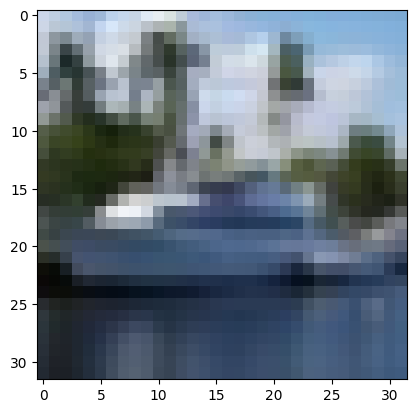

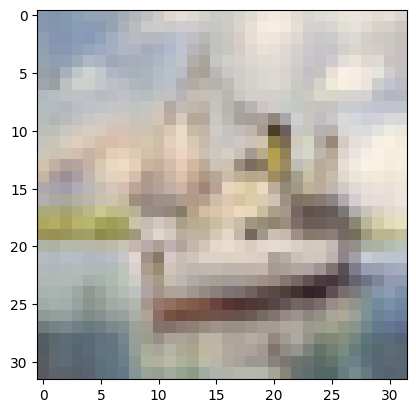

In [4]:
# Visualize some data samples of class '1' (car)
import matplotlib.pyplot as plt
imgplot = plt.imshow(train_set[0])
plt.show()
imgplot = plt.imshow(train_set[1])
plt.show()

# Build the generator

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Conv2DTranspose, LeakyReLU, Reshape, Dropout, BatchNormalization, GlobalMaxPooling2D

# Define the structure of Generator
def define_generator(latent_dim):
  # latent_dim: dimension of the random input vector

  model = Sequential() # Initialize a sequential model for Generator

  # Foundation for 4x4 image
  n_nodes = 4*4*256 # Expected vector size for converting to a feature map
  model.add(Dense(input_dim=latent_dim, units=n_nodes)) # FC layer to convert latent vector to a vector of size n_nodes
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4, 4, 256)))

  # Upsample from 4x4x256 to 8x8x128 using Conv2DTranspose
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #model.add(BatchNormalization())

  # Upsample from 8x8x128 to 16x16x128
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #model.add(BatchNormalization())

  # Upsample from 16x16x128 to 32x32x128
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #model.add(BatchNormalization())

  # Convert from 32x32x128 to 32x32x3 conforming to Discriminator's input
  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))

  return model # Return the Generator

# Show a sample of Generator structure
generator = define_generator(128)
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              528384    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                              

#Build the discriminator

In [6]:
# Define the structure of Discriminator
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential() # Initialize a sequential model for Discriminator

  # Block 1 conv
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  #model.add(Dropout(0.5))

  # Block 2 conv
  model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
  #model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  #model.add(Dropout(0.5))

  # Block 3 conv
  model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
  #model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  #model.add(Dropout(0.5))

  # Block 4 conv
  model.add(Conv2D(256, (3,3), strides=(2, 2), padding='same'))
  #model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))

  model.add(Flatten())
  model.add(Dropout(0.4))

  # Classifier
  #model.add(GlobalMaxPooling2D())
  model.add(Dense(1, activation='sigmoid'))

  return model # Return the Discriminator

# Show a sample of Discriminator structure
sample_discriminator = define_discriminator()
sample_discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 4, 4, 128)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 2, 256)        

#Build the GAN with generator and discriminator

In [7]:
# Define the GAN network consisting of a Generator and a Discriminator
def define_gan(g_model, d_model):
    # g_model: Generator component
    # d_model: Discriminator component

    model = Sequential() # Initialize a sequential model
    model.add(g_model) # Add the Generator component
    model.add(d_model) # Add the Discriminator component
    return model # Return the GAN

#Prepare real data samples from Cifar-10 dataset

In [8]:
def load_real_samples(class_index):
    # Load CIFAR-10 dataset
    (trainX, trainY), (_, _) = cifar10.load_data()
    # Filter images for the desired class
    X = trainX[trainY.flatten() == class_index]
    # Normalize images
    #X = X.astype('float32') / 255.0
    X = X.astype('float32')
    X = (X - 127.5) / 127.5
    # Return the set of normalized images
    return X

def generate_real_samples(dataset, n_samples):
    # Generate random n_samples sample indices from the filtered class images
    ix = random.randint(0, dataset.shape[0], n_samples)
    # Get the images from the list of indices
    X = dataset[ix]
    # Generate labels for the real samples (label=1)
    y = ones((n_samples, 1))
    return X, y

#Generate fake data samples by passing a random vector through the Generator

In [9]:
# Generate random latent vectors as input for Generator
def generate_latent_points(latent_dim, n_samples):
    # Generate points in the latent space
    x_input = random.randn(latent_dim * n_samples)
    # Reshape to a batch of inputs for the Generator
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# Use Generator to generate n_samples fake samples
def generate_fake_samples(g_model, latent_dim, n_samples):
    # Generate random latent vectors as input for Generator
    x_input = generate_latent_points(latent_dim, n_samples)
    # Generate fake data samples by passing the random latent vectors through the Generator
    X = g_model.predict(x_input)
    # Generate labels for the fake samples (label=0)
    y = zeros((n_samples, 1))
    return X, y # Return the fake images and labels.

# Training process with the Generator and the Discriminator

In [10]:
# Train the Generator and the Discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=201, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch) # Number of iterations per epoch
    half_batch = int(n_batch / 2) # A batch to the Discriminator contains real samples (half-batch) and fake samples (half-batch)

    d_loss_values = [] # Array containing Discriminator loss over iterations
    g_loss_values = [] # Array containing Generator loss over iterations

    # Number of epochs
    for i in range(n_epochs):
        # Number of iterations
        for j in range(bat_per_epo):

            # Randomly get half_batch real data samples from the real dataset
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # Generate half_batch fake data samples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # Create training set for the discriminator: half-batch real and half-batch fake
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))

            # Update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)

            # Generate random latent vectors as input for Generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # Generate inverted labels for the fake samples to train the Generator
            y_gan = ones((n_batch, 1))
            # Train the Generator
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # Training log after every iteration
            print('Epoch %d, Iteration %d/%d, D_loss = %.3f, G_loss = %.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

            # Add loss values to historical arrays
            d_loss_values.append(d_loss)
            g_loss_values.append(g_loss)

        # Plot the generated images every certain number of epochs
        if (i+1) % 10 == 0:
            X_fake, _ = generate_fake_samples(g_model, latent_dim, 100) # Generate 100 fake data samples using the Generator. Pixel values are in [0,1]
            save_plot(X_fake, i, n=10) # Plot a grid of 10x10 fake samples and save to file at epoch i

    return d_loss_values, g_loss_values # Return the loss arrays of Generator and Discriminator

# Plot the Generator's outputs

In [11]:
# Create and save a plot of generated images
def save_plot(samples, epoch, n=10):
    # scale from [-1,1] to [0,1]
    samples = (samples + 1) / 2.0
    # Define a plot of (n rows, n columns)
    for i in range(n * n):
        # (1+i) is the index position on a grid with nrows rows and ncols columns. Index starts at 1 in the upper left corner and increases to the right.
        plt.subplot(n, n, 1+i)
        plt.axis('off') # Disable axis
        plt.imshow(samples[i]) # Plot the sample i
    filename = 'Plot_epoch_%03d.png' % (epoch+1)
    plt.savefig(filename) # Save plot to file
    plt.close() # Close the plot

#Main code

In [12]:
# Import optimization library
from keras.optimizers import Adam, SGD

# Size of the latent space
latent_dim = 128
epochs = 200
batch_size = 128
class_index = 8

# Initialize an optimizer. Pick one.
opt = Adam(learning_rate=0.0002, beta_1=0.5) # Adam optimizer with customized values (for the best result)
# opt = Adam() # Adam optimizer with default values
# opt = SGD() # SGD optimizer with default values

# Create the Discriminator
d_model = define_discriminator()
d_model.trainable = True
d_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Create the Generator
g_model = define_generator(latent_dim)

# Create the GAN
d_model.trainable = False
gan_model = define_gan(g_model, d_model)
gan_model.compile(loss='binary_crossentropy', optimizer=opt)

# Load real image data from the MNIST dataset
dataset = load_real_samples(class_index)

# Train the GAN
d_losses, g_losses = train(g_model, d_model, gan_model, dataset, latent_dim, epochs, batch_size)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
Epoch 137, Iteration 1/39, D_loss = 0.678, G_loss = 0.788
2/2 [==============================] - 0s 4ms/step
Epoch 137, Iteration 2/39, D_loss = 0.703, G_loss = 0.838
2/2 [==============================] - 0s 5ms/step
Epoch 137, Iteration 3/39, D_loss = 0.663, G_loss = 0.844
2/2 [==============================] - 0s 4ms/step
Epoch 137, Iteration 4/39, D_loss = 0.681, G_loss = 0.860
2/2 [==============================] - 0s 4ms/step
Epoch 137, Iteration 5/39, D_loss = 0.661, G_loss = 0.864
2/2 [==============================] - 0s 5ms/step
Epoch 137, Iteration 6/39, D_loss = 0.645, G_loss = 0.904
2/2 [==============================] - 0s 4ms/step
Epoch 137, Iteration 7/39, D_loss = 0.633, G_loss = 0.880
2/2 [==============================] - 0s 4ms/step
Epoch 137, Iteration 8/39, D_loss = 0.658, G_loss = 0.848
2/2 [==============================] - 0s 5ms/step
Epoch 137, Iteration 9/39,

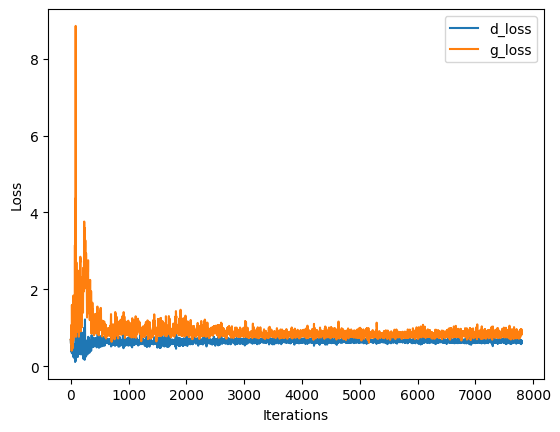

In [13]:
### Plot the training loss of the Generator and the Discriminator over iterations

# Initialize values of x-axis (iterations)
dx = np.linspace(0, len(d_losses), len(d_losses))
gx = np.linspace(0,len(g_losses), len(d_losses))

# Plot the training loss of G and D
plt.plot(dx, d_losses)
plt.plot(gx, g_losses)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(['d_loss', 'g_loss'], loc='upper right')
plt.show()

#Save and load the models

In [14]:
# Save the Discriminator, Generator and GAN model
d_model.save('d_model.sav')
g_model.save('g_model.sav')
gan_model.save('gan_model.sav')

4/4 [==============================] - 0s 7ms/step


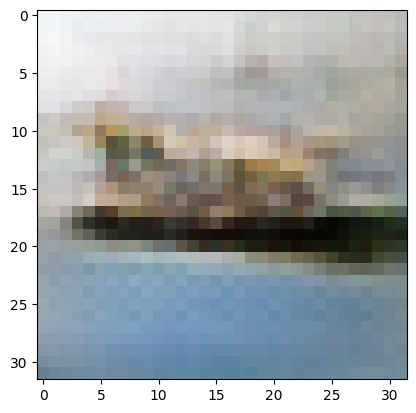

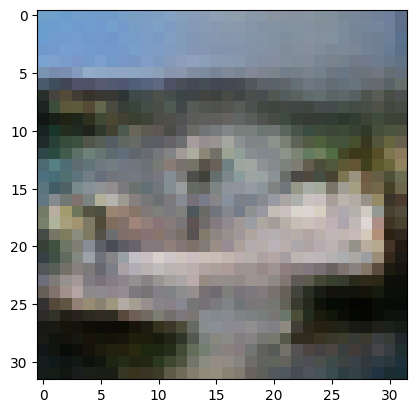

In [15]:
# Load the Generator from saved model
g_model = keras.models.load_model("g_model.sav")

# Generate 100 fake images by passing 100-dimensional random vectors through the Generator.
X_fake, _ = generate_fake_samples(g_model, 128, 100)
X_fake = (X_fake + 1) / 2.0
# Visualize the generated images
imgplot = plt.imshow(X_fake[3].squeeze())
plt.show()
imgplot = plt.imshow(X_fake[4].squeeze())
plt.show()

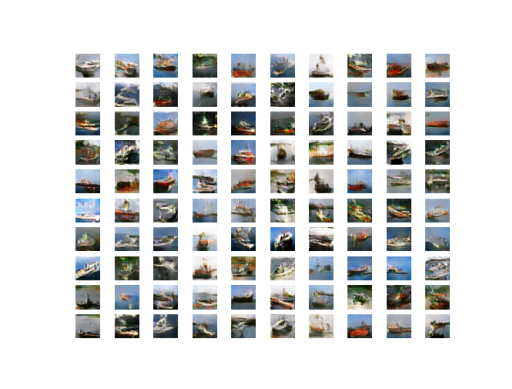

In [16]:
import cv2
image = cv2.imread('/content/Plot_epoch_200.png')
# Convert BGR image to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using plt.imshow()
plt.imshow(image_rgb)
plt.axis('off')  # Optional: Turn off the axis labels
plt.show()

In [17]:
import imageio
import os

# Specify the directory containing the saved image files
directory = '/content'  # Replace with the actual path to the directory where the images are located

# Get a list of all image file names in the directory
file_names = sorted([f for f in os.listdir(directory) if f.endswith('.png')])

# Create an empty list to store the image frames
frames = []

# Read each image file and append it to the frames list
for file_name in file_names:
    file_path = os.path.join(directory, file_name)
    frames.append(imageio.imread(file_path))

# Define the path and filename for the generated GIF
gif_path = '/content/generated_gif.gif'  # Replace with the desired path and filename for the generated GIF

# Save the frames as a GIF
imageio.mimsave(gif_path, frames, duration=0.2)  # Adjust the duration parameter as needed

print("GIF created successfully.")


<ipython-input-17-b2feb43a414d>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(file_path))


GIF created successfully.


In [18]:
from IPython.display import Image

# Specify the path of the GIF file
gif_path = '/content/generated_gif.gif'  # Replace with the actual path of the GIF file

# Display the GIF
Image(filename=gif_path)


Output hidden; open in https://colab.research.google.com to view.